In [ ]:
done = False

# Homework 6
### ASTR-324, University of Washington


## Problem

Quoting from [Sesar et al. (2017)](https://iopscience.iop.org/article/10.3847/1538-3881/aa661b):

> RR Lyrae stars are old ($\mathrm{age}\gt 10$ Gyr), metal-poor ($[\mathrm{Fe}/{\rm{H}}]\ \lt \ -0.5$ dex), pulsating horizontal branch stars with periodically variable light curves (periods ranging from 0.2 to 0.9 days; Smith 2004). They are bright stars (${M}_{{\rm{V}}}=0.6\pm 0.1$ mag) with distinct light curves, which makes them easy to identify with time-domain imaging surveys, even to large distances (5–120 kpc for surveys with a $14\lt V\lt 21$ magnitude range; e.g., Sesar et al. 2010). These properties, and the fact that almost every Milky Way dwarf satellite galaxy has at least one RR Lyrae star (including the faintest one, Segue 1; Simon et al. 2011), open up the exciting possibility of locating very-low-luminosity Milky Way dwarf satellites by using distant RR Lyrae stars, as first proposed by Sesar et al. (2014; also see Baker & Willman 2015).

The file `data/rrlyra.dataset.txt` contains observations of a single RRLyrae, found in a dwarf galaxy, over approximately a 3-month period, with the first column being the time (in days), and the second column being the $i$-band magnitude, $m_i$.

* Compute the average apparent magnitude of the RR Lyrae, $\bar{m_i}$
* Find the most likely period $P$ of the RR Lyrae, using a Lomb-Scargle periodogram.
* RR-Lyrae observe a period-luminosity relation in the $i$ band:

  $$ M_i = -1.77 \log_{10} \frac{P}{0.6\,\mathrm{days}} + 0.46 $$
  
  Use this relation, and the estimated period $P$, to estimate the absolute magnitude $M_i$ of this RR Lyra.
* Using the RR Lyra's absolute magnitude $M_i$, and the average apparent magnitude $\bar{m_i}$, estimate the distance to the dwarf galaxy where this star resides.

The data:

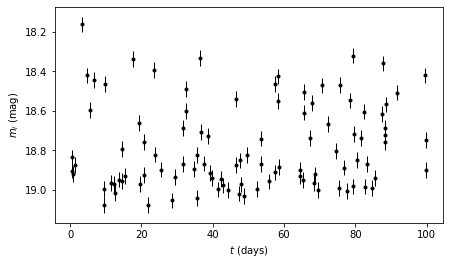

In [1]:
%matplotlib inline

import numpy as np
from matplotlib import pyplot as plt

# read data
data = np.loadtxt('data/rrlyra.dataset.txt', unpack=True)
t, y_obs, sigma_y = data

# plot data
fig = plt.figure(figsize=(12, 12))
ax = fig.add_axes([0.5, 0.7, 0.45, 0.25])
ax.errorbar(t, y_obs, sigma_y, fmt='.', lw=1, c='k')
ax.set_xlabel(r'$t$ (days)')
ax.set_ylabel(r'$m_i$ (mag)')
ax.invert_yaxis()

## Solution

In [2]:
# To remain consistent with the textbook, we'll use some functions that have 
# been deprecated in recent versions of astroML. This code silences the
# distracting deprecation warnings related to these.

import warnings
from astroML.utils.exceptions import AstroMLDeprecationWarning
warnings.filterwarnings("ignore", category=AstroMLDeprecationWarning)

Average apparent magnitude:

In [8]:
avg_mi = np.mean(data[1])
print(f'''The average apparent magnitude is {avg_mi:.2f}''')

The average apparent magnitude is 18.78


Finding the most likely period using LS periodigram:

In [15]:
dy = sigma_y

In [9]:
# Similar to Figure 10.15 in the textbook

# plot phased light curve with times t, observations y_obs, and period P
def plot_phased(t, y_obs, P, ax = None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(14,7))

    phase = t / P - np.floor(t/P)
    ax.errorbar(phase, y_obs, dy, fmt='.k', lw=1, ecolor='gray')
    ax.set_xlabel('phase')
    ax.set_ylabel('flux')
    ax.set_xlim(-0.05, 1.05)
    
# plot phased light curve and periodogram
# times: t, observations: y_obs, period: P_fit,
# 1%/5% false alarm probability thresholds for P_LS: sig1/sig5
def plot_LS(t, y_obs, P_fit, sig1, sig5):
    #------------------------------------------------------------
    # Plot the results
    fig = plt.figure(figsize=(14, 7))
    fig.subplots_adjust(left=0.1, right=0.9, hspace=0.25)

    # First panel: the data
    ax = fig.add_subplot(211)
    plot_phased(t, y_obs, P_fit, ax=ax)

    # Second panel: the periodogram & significance levels
    ax1 = fig.add_subplot(212, xscale='log')
    ax1.plot(period, PS, '-', c='black', lw=1, zorder=1)
    ax1.plot([period[0], period[-1]], [sig1, sig1], ':', c='black', label="99% significance level")
    ax1.plot([period[0], period[-1]], [sig5, sig5], '-.', c='black', label="95% significance level")
    ax1.legend()

    ax1.annotate("", (P_fit, 0.95), (P_fit, 1.10), ha='center', arrowprops=dict(arrowstyle='->'))

    ax1.set_xlim(period[0], period[-1])
    ax1.set_ylim(-0.05, 1.15)

    ax1.set_xlabel(r'period (days)')
    ax1.set_ylabel('power')

    # Twin axis: label BIC on the right side
    ax2 = ax1.twinx()
    ax2.set_ylim(tuple(lomb_scargle_BIC(ax1.get_ylim(), y_obs, dy)))
    ax2.set_ylabel(r'$\Delta BIC$')

    ax1.xaxis.set_major_formatter(plt.FormatStrFormatter('%.1f'))
    ax1.xaxis.set_minor_formatter(plt.FormatStrFormatter('%.1f'))
    ax1.xaxis.set_major_locator(plt.LogLocator(10))
    ax1.xaxis.set_major_formatter(plt.FormatStrFormatter('%.3g'))

    plt.show()

In [16]:
from astroML.time_series import lomb_scargle, lomb_scargle_BIC, lomb_scargle_bootstrap

#------------------------------------------------------------
# Compute periodogram
period = 10 ** np.linspace(-1, 0, 10000)
omega = 2 * np.pi / period
PS = lomb_scargle(t, y_obs, dy, omega, generalized=True)

# find the highest peak
P_fit = period[PS.argmax()]

#------------------------------------------------------------
# Get significance via bootstrap
D = lomb_scargle_bootstrap(t, y_obs, dy, omega, generalized=True,
                           N_bootstraps=500, random_state=0)
sig1, sig5 = np.percentile(D, [99, 95])

        Use astropy.stats.LombScargle instead. [warnings]
        Use astropy.stats.LombScargle.false_alarm_probability instead. [warnings]
        Use astropy.stats.LombScargle instead. [astroML.time_series.periodogram]


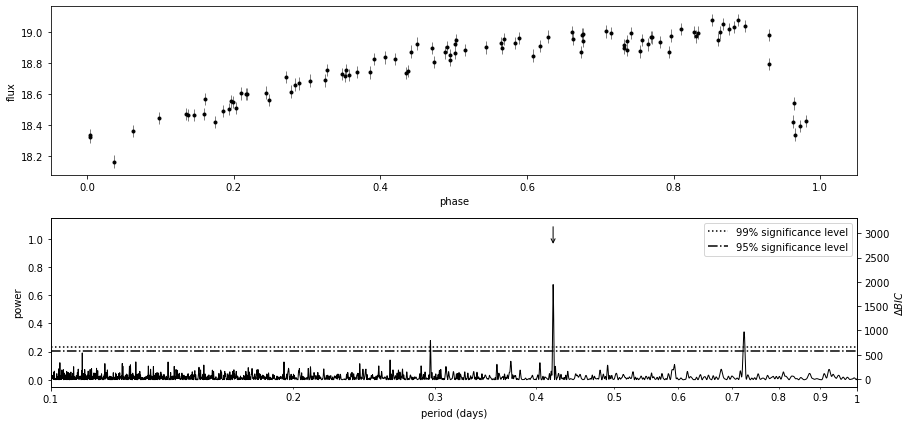

The most likely period for this RR Lyra is P_fit = 0.420 days


In [19]:
plot_LS(t, y_obs, P_fit, sig1, sig5)
print(f"The most likely period for this RR Lyra is P_fit = {P_fit:.3f} days")

Estimate the absolute magnitude of this RR Lyra

  $$ M_i = -1.77 \log_{10} \frac{P}{0.6\,\mathrm{days}} + 0.46 $$

In [21]:
abs_mag = -1.77*np.log10(P_fit/0.6)+0.46
print(f'''The estimated absolute magnitude of this RR Lyra is {abs_mag:.2f}.''')

The estimated absolute magnitude of this RR Lyra is 0.73.


Using the absolute magnitude and the average apparent magnitude, estimate the distance to the galaxy where the star resides:

In [28]:
dist_mod = avg_mi - abs_mag
distance = 10**((dist_mod/5)+1)
print(f'''The estimated distance to this dwarf galaxy is {distance:.0f} parsecs.''')

The estimated distance to this dwarf galaxy is 40682 parsecs.
